# **Breast Cancer Classification Project**

This notebook builds a Breast Cancer Classification Model using Convolutional Neural Networks (CNNs). The model is trained on histopathological image data to classify samples as cancerous or non-cancerous.

Key Highlights:

* Data preprocessing and augmentation techniques are applied to prepare the dataset.
* A CNN model is designed and trained using TensorFlow and Keras.
* Model performance is evaluated based on accuracy during training and validation.
* Visualizations of training and validation loss and accuracy are provided to assess performance.
* Achieved an accuracy of 93% on the test dataset.
* The model is saved in .h5 format for deployment purposes.

In [ ]:
!nvidia-smi

Sat Jan  4 21:55:22 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              44W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
from google.colab import files
files.upload()


{}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d ambarish/breakhis


Dataset URL: https://www.kaggle.com/datasets/ambarish/breakhis
License(s): unknown
100% 3.98G/3.99G [03:01<00:00, 24.4MB/s]
100% 3.99G/3.99G [03:01<00:00, 23.6MB/s]


In [ ]:
import zipfile
with zipfile.ZipFile("breakhis.zip", 'r') as zip_ref:
    zip_ref.extractall("breakhis_data")


In [ ]:
import os
print(os.listdir("breakhis_data"))


['Folds.csv', 'BreaKHis_v1']


In [ ]:
# Essential Libraries
import os
import cv2
import json
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

# TensorFlow Keras Imports
from tensorflow.keras import layers, Sequential
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

# Sklearn for Model Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score, classification_report, confusion_matrix
from sklearn import metrics
from collections import Counter

# Progress Bar Utility
from tqdm import tqdm


In [ ]:
import os
import numpy as np
import cv2
from PIL import Image
from tqdm import tqdm

# Dataset Loader Function
def Dataset_loader(DIR, LABEL, RESIZE, sigmaX=10):
    IMG = []
    LABELS = []  # Store labels
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

    # Walk through all subdirectories
    for root, dirs, files in os.walk(DIR):
        for IMAGE_NAME in tqdm(files):
            PATH = os.path.join(root, IMAGE_NAME)
            _, ftype = os.path.splitext(PATH)
            # Process only valid image formats
            if ftype.lower() in ['.png', '.jpg', '.jpeg']:
                img = read(PATH)

                # Resize image
                img = cv2.resize(img, (RESIZE, RESIZE))

                # Optional Gaussian Blur
                img = cv2.GaussianBlur(img, (5, 5), sigmaX)

                IMG.append(np.array(img))
                LABELS.append(LABEL)  # Add label (0 or 1)

    return np.array(IMG), np.array(LABELS)

# Load Benign Images (Label = 0)
benign_images, benign_labels = Dataset_loader(
    '/content/breakhis_data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign', 0, 224)

# Load Malignant Images (Label = 1)
malign_images, malign_labels = Dataset_loader(
    '/content/breakhis_data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant', 1, 224)

# Combine Datasets
X = np.concatenate((benign_images, malign_images), axis=0)
Y = np.concatenate((benign_labels, malign_labels), axis=0)

print("Dataset Shape:")
print("X:", X.shape)
print("Y:", Y.shape)


100%|██████████| 6/6 [00:00<00:00, 48118.21it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 23/23 [00:00<00:00, 73.50it/s]
0it [00:00, ?it/s]
100%|██████████| 16/16 [00:00<00:00, 110.83it/s]
0it [00:00, ?it/s]
100%|██████████| 21/21 [00:00<00:00, 79.38it/s]
0it [00:00, ?it/s]
100%|██████████| 12/12 [00:00<00:00, 107.76it/s]
0it [00:00, ?it/s]
100%|██████████| 17/17 [00:00<00:00, 105.65it/s]
0it [00:00, ?it/s]
100%|██████████| 16/16 [00:00<00:00, 100.79it/s]
0it [00:00, ?it/s]
100%|██████████| 35/35 [00:00<00:00, 75.16it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 17/17 [00:00<00:00, 111.26it/s]
0it [00:00, ?it/s]
100%|██████████| 18/18 [00:00<00:00, 106.63it/s]
0it [00:00, ?it/s]
100%|██████████| 32/32 [00:00<00:00, 72.59it/s]
0it [00:00, ?it/s]
100%|██████████| 38/38 [00:00<00:00, 74.69it/s]
0it [00:00, ?it/s]
100%|██████████| 18/18 [00:00<00:00, 106.68it/s]
0it [00:00, ?it/s]
100%|██████████| 37/37 [00:00<00:00, 77.13it/s]
0it [00:00, ?it/

Dataset Shape:
X: (7909, 224, 224, 3)
Y: (7909,)


In [ ]:
benign_label = np.zeros(len(benign_images))  # 0 for benign
malign_label = np.ones(len(malign_images))  # 1 for malignant

# Combine Data
X = np.concatenate((benign_images, malign_images), axis=0)
Y = np.concatenate((benign_label, malign_label), axis=0)

print("X Shape:", X.shape)
print("Y Shape:", Y.shape)


X Shape: (7909, 224, 224, 3)
Y Shape: (7909,)


In [ ]:
# Shuffling the data as we have one class as values then another class as values in my data thorugh concatemnation:
s = np.arange(X.shape[0])
np.random.shuffle(s)
X = X[s]
Y = Y[s]

Y = to_categorical(Y, num_classes= 2)

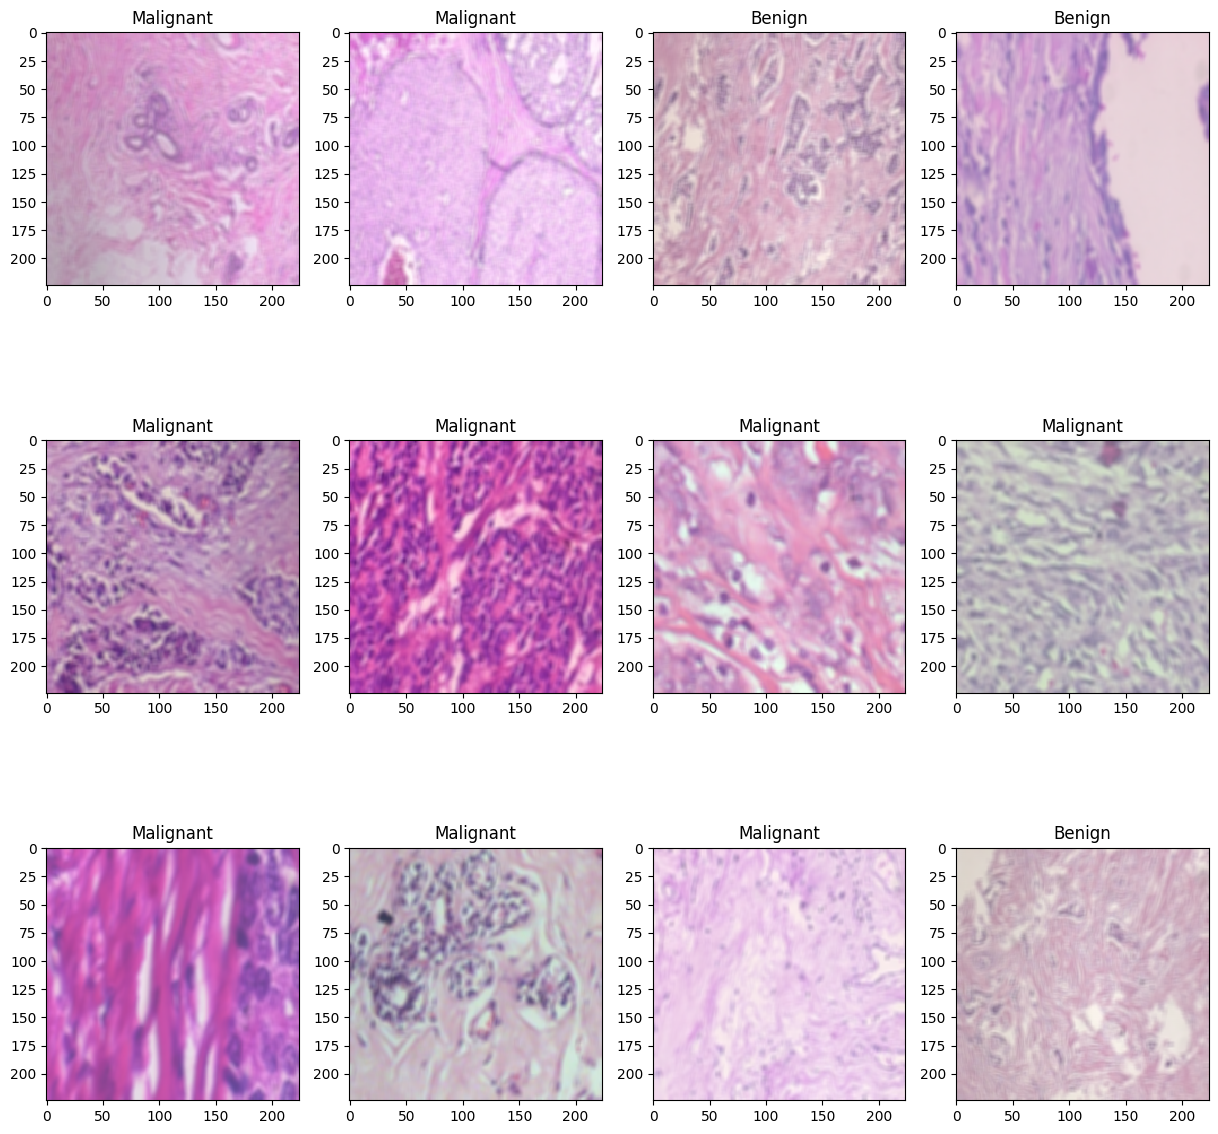

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [ ]:
# Image preprocessing part - 2

BATCH_SIZE = 32

train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Shape after base_model: (None, 7, 7, 1920)
Shape after GlobalAveragePooling2D(): (None, 1920)


Model: "breast_cancer_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet201 (Functional)             │ (None, 7, 7, 1920)          │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 1920)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_layer (Dropout)              │ (None, 1920)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_norm_layer                     │ (None, 1920)                │           7,680 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │           1,921 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,331,585 (69.93 MB)

 Trainable params: 5,761 (22.50 KB)

 Non-trainable params: 18,325,824 (69.91 MB)

Epoch 1/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 90s 260ms/step - accuracy: 0.6807 - loss: 0.6202 - val_accuracy: 0.8300 - val_loss: 0.4303
Epoch 2/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.8031 - loss: 0.4727 - val_accuracy: 0.8325 - val_loss: 0.3957
Epoch 3/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.8138 - loss: 0.4452 - val_accuracy: 0.8382 - val_loss: 0.3824
Epoch 4/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.8144 - loss: 0.4492 - val_accuracy: 0.8401 - val_loss: 0.3727
Epoch 5/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.8219 - loss: 0.4311 - val_accuracy: 0.8458 - val_loss: 0.3667
Epoch 6/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.8233 - loss: 0.4370 - val_accuracy: 0.8470 - val_loss: 0.3629
Epoch 7/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.8195 - loss: 0.4285 - val_accuracy: 0.8502 - val_loss: 0.3577
Epoch 8/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.8376 - loss: 0.4016 - val_ac

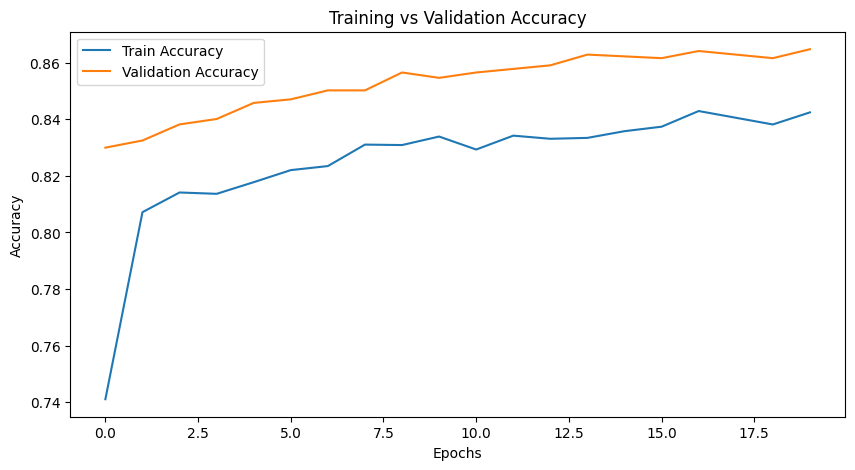

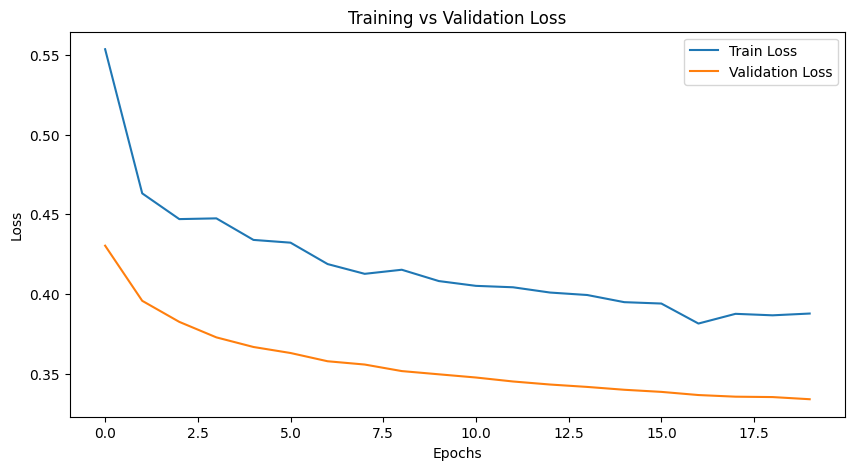

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# 1. Preprocess the labels (convert one-hot to binary format)
y_train = np.argmax(y_train, axis=1)  # Converts [1, 0] -> 0 and [0, 1] -> 1
y_val = np.argmax(y_val, axis=1)

# 2. Create base model with DenseNet201
base_model = tf.keras.applications.DenseNet201(
    include_top=False,          # Remove the top layer for custom output
    weights='imagenet',         # Pre-trained on ImageNet
    input_shape=(224, 224, 3)   # Input shape of the images
)

# 3. Freeze the base model (to retain pre-trained patterns)
base_model.trainable = False

# 4. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 5. Pass the inputs through the base model
x = base_model(inputs, training=False)  # Frozen base model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D(): {x.shape}")

# 7. Add dropout and batch normalization for regularization
x = tf.keras.layers.Dropout(0.5, name="dropout_layer")(x)
x = tf.keras.layers.BatchNormalization(name="batch_norm_layer")(x)

# 8. Create the output layer for binary classification
outputs = tf.keras.layers.Dense(1, activation="sigmoid", name="output_layer")(x)

# 9. Combine the inputs and outputs into a model
model = tf.keras.Model(inputs, outputs, name="breast_cancer_model")

# 10. Compile the model
model.compile(
    loss='binary_crossentropy',                      # Binary classification loss
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Adam optimizer with learning rate
    metrics=["accuracy"]                            # Evaluate using accuracy metric
)

# 11. Print model summary
model.summary()

# 12. Train the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),  # Validation data
    epochs=20,                       # Number of epochs
    batch_size=32,                   # Batch size
    shuffle=True                      # Shuffle data during training
)


# 14. Evaluate performance

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()



In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# ========================
# 1. Load Pre-trained Model
# ========================
base_model = tf.keras.applications.DenseNet201(
    include_top=False,        # Remove the top layer for custom output
    weights='imagenet',       # Use pre-trained weights
    input_shape=(224, 224, 3) # Input shape
)

# Unfreeze the base model for fine-tuning
base_model.trainable = True

# Freeze all layers except the last 10 for fine-tuning
for layer in base_model.layers[:-50]:
    layer.trainable = False

# ====================
# 2. Build the Model
# ====================
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# Pass through the pre-trained model
x = base_model(inputs, training=True)  # Fine-tune the pre-trained model

# Add pooling, dropout, and batch normalization
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)  # Dropout for regularization
x = tf.keras.layers.BatchNormalization()(x)

# Output layer for binary classification
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

# Combine inputs and outputs
model = tf.keras.Model(inputs, outputs, name="breast_cancer_model")

# ======================
# 3. Compile the Model
# ======================
model.compile(
    loss='binary_crossentropy',                                # Binary classification loss
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),    # Lower learning rate for fine-tuning
    metrics=["accuracy"]                                       # Evaluate using accuracy
)

# ============================
# 4. Callbacks for Fine-tuning
# ============================
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy', patience=3, factor=0.1, min_lr=1e-7, verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
)

# ============================
# 5. Fine-Tune the Model
# ============================
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=50,  # Fine-tune for more epochs
    batch_size=32,
    callbacks=[lr_scheduler, early_stopping],
    shuffle=True
)



Epoch 1/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 92s 240ms/step - accuracy: 0.6710 - loss: 0.6166 - val_accuracy: 0.8369 - val_loss: 0.4680 - learning_rate: 1.0000e-05
Epoch 2/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.7950 - loss: 0.5096 - val_accuracy: 0.8559 - val_loss: 0.4039 - learning_rate: 1.0000e-05
Epoch 3/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.8157 - loss: 0.4637 - val_accuracy: 0.8654 - val_loss: 0.3752 - learning_rate: 1.0000e-05
Epoch 4/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.8194 - loss: 0.4571 - val_accuracy: 0.8685 - val_loss: 0.3589 - learning_rate: 1.0000e-05
Epoch 5/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.8346 - loss: 0.4224 - val_accuracy: 0.8742 - val_loss: 0.3505 - learning_rate: 1.0000e-05
Epoch 6/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.8407 - loss: 0.4191 - val_accuracy: 0.8742 - val_loss: 0.3311 - learning_rate: 1.0000e-05
Epoch 7/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - a

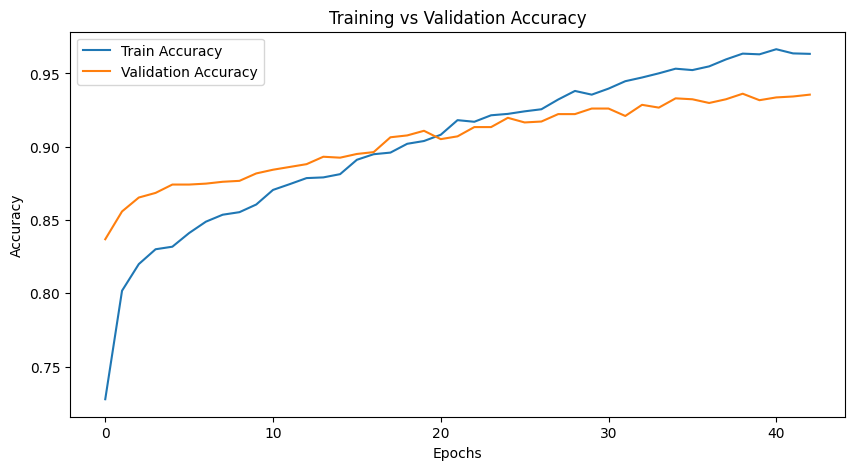

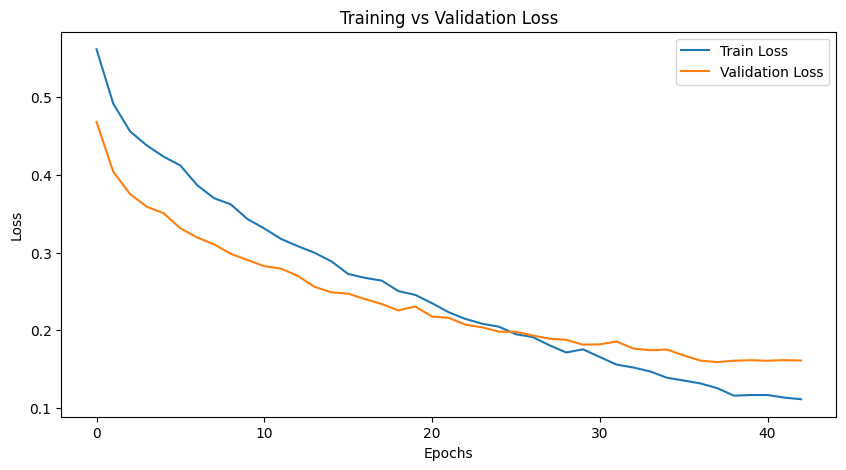

In [ ]:
# 14. Evaluate performance

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()



In [ ]:
# Print final training and validation accuracy
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_train_accuracy * 100:.2f}%")
print(f"Final Validation Accuracy: {final_val_accuracy * 100:.2f}%")


Final Training Accuracy: 96.33%
Final Validation Accuracy: 93.55%


In [ ]:
model.save('breast_cancer_model.h5')


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('/content/breast_cancer_model.h5')

# Evaluate the loaded model
test_loss, test_accuracy = loaded_model.evaluate(x_val, y_val, verbose=1)

# Print evaluation results
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 149ms/step - accuracy: 0.9219 - loss: 0.1762
Test Accuracy: 93.24%
Test Loss: 0.1590
